In [3]:
import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.nn.functional as F  # Functional module, includes activation functions
import torch.optim as optim  # Optimization module
import torchvision  # Vision / image processing package built on top of torch
import typing
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt  # Plotting and visualization
from sklearn.metrics import accuracy_score  # Computing accuracy metric

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [43]:
def load_data() -> typing.Tuple[DataLoader, DataLoader]:
    # Any data augmentation should be added to training
    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
    ])

    # Test data should have normalization applied, but no augmentation
    test_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
    ])

    # Download the MNIST data and lazily apply the transformation pipeline
    train_data = torchvision.datasets.MNIST('./datafiles/', train=True, download=True, transform=train_transform)
    test_data = torchvision.datasets.MNIST('./datafiles/', train=False, download=True, transform=test_transform)

    # Setup data loaders
    # Note: Iterating through the dataloader yields batches of (inputs, targets)
    # where inputs is a torch.Tensor of shape (B, 1, 28, 28) and targets is a torch.Tensor of shape (B,)
    BATCH_SIZE = 512
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000)
    return train_loader, test_loader

def visualize_batch(data_loader: DataLoader) -> None:
    # Plot examples of transformations
    fig, axs = plt.subplots(4, 5, figsize=(5, 6))

    plot_images = []
    plot_labels = []

    for images, labels in data_loader:
        for i in range(images.shape[0]):
            plot_images.append(images[i])
            plot_labels.append(labels[i])
            if len(plot_images) >= 20:
                break
        if len(plot_images) >= 20:
            break
    
    for i in range(4):
        for j in range(5):
            axs[i, j].imshow(plot_images[i * 5 + j].squeeze(), cmap='gray')
            axs[i, j].set_title(f"Label: {plot_labels[i * 5 + j].item()}")
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()
    return
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    model = model.to(DEVICE)
    model.train()  # Set model in training mode

    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.to(DEVICE))
        loss.backward()
        optimizer.step()

        # Track some values to compute statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=-1)
        all_predictions.extend(preds.detach().cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy

    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []

    model = model.to(DEVICE)
    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(inputs.to(DEVICE))
            loss = loss_fn(outputs, targets.to(DEVICE))

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            all_predictions.extend(preds.detach().cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.2f}, average test accuracy = {acc * 100:.3f}%")
    return acc, final_loss


train_loader, test_loader = load_data()

## Baseline Architecture with one convolutional layer with 16 out-channels and one fully connected layer with 10 outputs.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaselineConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers with stride for downsampling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)

        # Fully connected layers
        dim = 28 * 28 * 16
        self.fc1 = nn.Linear(28 * 28 * 16, 10)

    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))   # (batch, 16, 28, 28)
        
        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)
        
        # Fully connected layers
        x = self.fc1(x)

        return x


In [45]:

def training_loop(model, loss_fn, optimizer, num_epochs=10, learning_rate=0.001, show_plots=True):
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
        test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    if not show_plots:
        return train_accuracies, test_accuracies, train_losses, test_losses

    # Plot accuracies
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
    axs[0].plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
    axs[0].set_title("Accuracy over Epochs")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Plot losses
    axs[1].plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    axs[1].plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
    axs[1].set_title("Loss over Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.show()
    plt.close()
    return train_accuracies, test_accuracies, train_losses, test_losses

Epoch 1 done. Average train loss = 0.39, average train accuracy = 88.335%
Epoch 1 done. Average test loss = 0.21, average test accuracy = 94.130%
Epoch 2 done. Average train loss = 0.16, average train accuracy = 95.483%
Epoch 2 done. Average test loss = 0.13, average test accuracy = 96.330%
Epoch 3 done. Average train loss = 0.10, average train accuracy = 97.085%
Epoch 3 done. Average test loss = 0.09, average test accuracy = 97.140%
Epoch 4 done. Average train loss = 0.08, average train accuracy = 97.850%
Epoch 4 done. Average test loss = 0.08, average test accuracy = 97.630%
Epoch 5 done. Average train loss = 0.06, average train accuracy = 98.235%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.860%
Epoch 6 done. Average train loss = 0.05, average train accuracy = 98.543%
Epoch 6 done. Average test loss = 0.07, average test accuracy = 97.850%
Epoch 7 done. Average train loss = 0.05, average train accuracy = 98.650%
Epoch 7 done. Average test loss = 0.07, average te

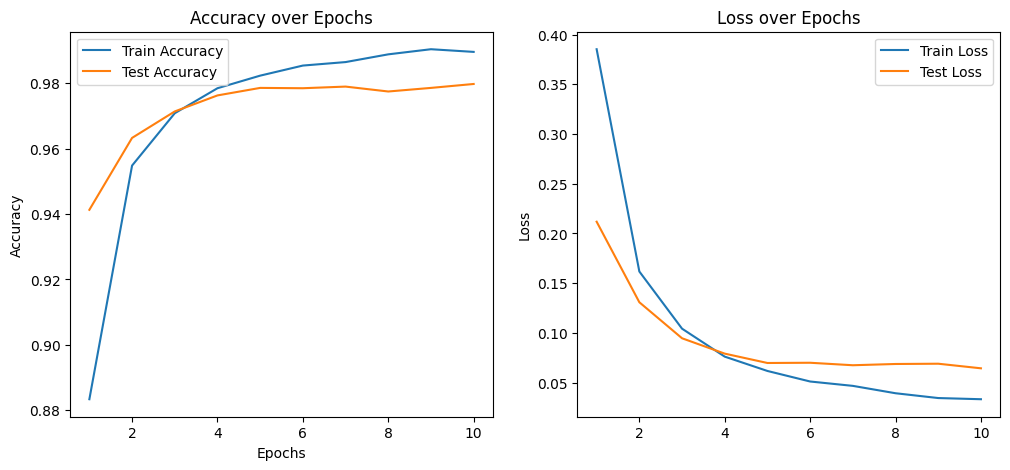

([0.88335,
  0.9548333333333333,
  0.97085,
  0.9785,
  0.98235,
  0.9854333333333334,
  0.9865,
  0.9888666666666667,
  0.9904333333333334,
  0.9896166666666667],
 [0.9413,
  0.9633,
  0.9714,
  0.9763,
  0.9786,
  0.9785,
  0.979,
  0.9775,
  0.9786,
  0.9798],
 [0.3852576932917207,
  0.16177519133030357,
  0.10427788944946507,
  0.07616287586673842,
  0.06175076948889231,
  0.05115421709872908,
  0.04676557128649142,
  0.03935050768619877,
  0.0345180971642672,
  0.03333766095466533],
 [0.21182626262307166,
  0.13083956725895404,
  0.0946232870221138,
  0.07917787749320268,
  0.06976756937801838,
  0.07000174634158611,
  0.0675037701614201,
  0.06876615937799216,
  0.06903755255043506,
  0.06442282637581229])

In [46]:
model = BaselineConvNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_loop(model=model, loss_fn=loss_fn, optimizer=optimizer, num_epochs=10, learning_rate=0.001, show_plots=True)

## Trying a few Architectures
- \# of Layers CNN and NN
- \# of Channels
- \# Pooling, Stride, Padding
- \# Kernel Size


## Testing Adding Convolutional Layers

Trying 1 - 4 layers of Covolutional Layers with 1 fully connected layer.

In [ ]:
class Variable_Convolution_Layers_CNN(nn.Module):

    def __init__(self, num_layers=1):
        super().__init__()
        # Convolutional layers with stride for downsampling
        self.num_layers = num_layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv_layers = [self.conv1, self.conv2, self.conv3, self.conv4]
        # Fully connected layersdimension based on num_layers
        dimension = 28 * 28 * 16
        print("Dimension: ", dimension)
        self.fc1 = nn.Linear(dimension, 10)

    def forward(self, x):
        for i in range(0, self.num_layers):
            x = F.relu(self.conv_layers[i](x))

        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)

        # Fully connected layers
        x = self.fc1(x)

        return x


Training CNN with 1 convolutional layers:

Dimension:  12544
Epoch 1 done. Average train loss = 0.35, average train accuracy = 89.817%
Epoch 1 done. Average test loss = 0.16, average test accuracy = 95.310%
Epoch 2 done. Average train loss = 0.14, average train accuracy = 96.253%
Epoch 2 done. Average test loss = 0.11, average test accuracy = 96.630%
Epoch 3 done. Average train loss = 0.09, average train accuracy = 97.440%
Epoch 3 done. Average test loss = 0.09, average test accuracy = 97.210%
Epoch 4 done. Average train loss = 0.07, average train accuracy = 97.857%
Epoch 4 done. Average test loss = 0.09, average test accuracy = 97.210%
Epoch 5 done. Average train loss = 0.06, average train accuracy = 98.223%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.950%

Training CNN with 2 convolutional layers:

Dimension:  12544
Epoch 1 done. Average train loss = 0.35, average train accuracy = 89.805%
Epoch 1 done. Average test loss = 0.13, average test accuracy = 96.260%


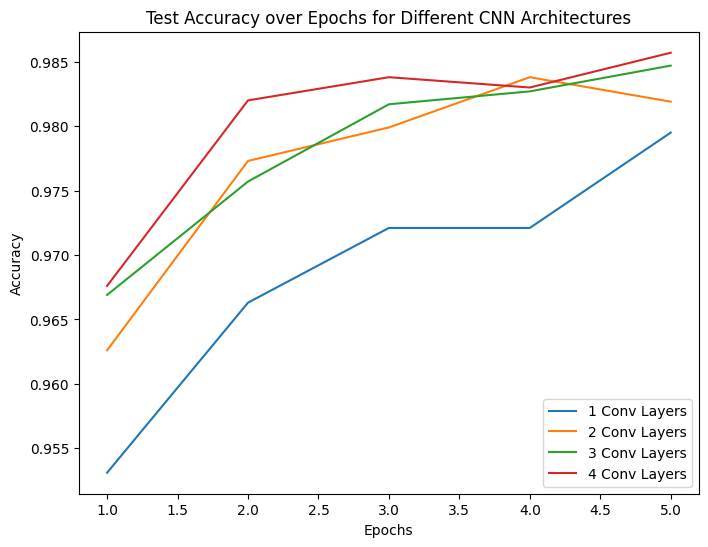

In [42]:
NUM_EPOCHS = 5
MAX_LAYERS = 4
training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for i in range(1, MAX_LAYERS + 1):
    print(f"\nTraining CNN with {i} convolutional layers:\n")
    cnn = Variable_Convolution_Layers_CNN(num_layers=i)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)
    # exit(0)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

#Plotting all test accuracies 1 plot

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(MAX_LAYERS):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=f"{i + 1} Conv Layers")
axs.set_title("Test Accuracy over Epochs for Different CNN Architectures")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()



In [47]:
class Variable_Number_Channels_CNN(nn.Module):

    def __init__(self, num_channels=16):
        super().__init__()
        # Convolutional layers with stride for downsampling
        self.conv1 = nn.Conv2d(1, num_channels, kernel_size=3, padding=1)

        # Fully connected layersdimension based on num_layers
        dimension = 28 * 28 * num_channels
        print("Dimension: ", dimension)
        self.fc1 = nn.Linear(dimension, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)

        # Fully connected layers
        x = self.fc1(x)

        return x


Training CNN with 8 channels in first convolutional layer:

Dimension:  6272
Epoch 1 done. Average train loss = 0.39, average train accuracy = 88.660%
Epoch 1 done. Average test loss = 0.23, average test accuracy = 93.360%
Epoch 2 done. Average train loss = 0.20, average train accuracy = 94.372%
Epoch 2 done. Average test loss = 0.16, average test accuracy = 95.560%
Epoch 3 done. Average train loss = 0.14, average train accuracy = 96.282%
Epoch 3 done. Average test loss = 0.12, average test accuracy = 96.510%
Epoch 4 done. Average train loss = 0.10, average train accuracy = 97.073%
Epoch 4 done. Average test loss = 0.10, average test accuracy = 97.240%
Epoch 5 done. Average train loss = 0.08, average train accuracy = 97.717%
Epoch 5 done. Average test loss = 0.08, average test accuracy = 97.490%

Training CNN with 16 channels in first convolutional layer:

Dimension:  12544
Epoch 1 done. Average train loss = 0.32, average train accuracy = 90.830%
Epoch 1 done. Average test loss = 0.14

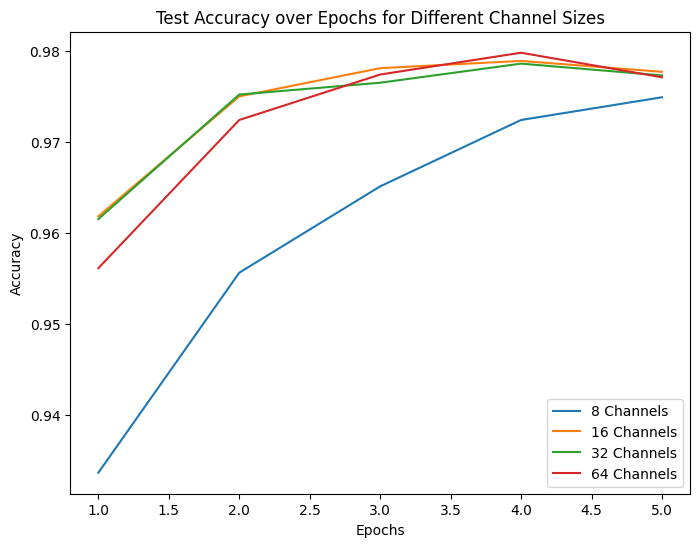

In [49]:
NUM_EPOCHS = 5
CHANNEL_OPTIONS = [8, 16, 32, 64]

training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for channels in CHANNEL_OPTIONS:
    print(f"\nTraining CNN with {channels} channels in first convolutional layer:\n")
    cnn = Variable_Number_Channels_CNN(num_channels=channels)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

#Plotting one accuracy plot
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(len(CHANNEL_OPTIONS)):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=f"{CHANNEL_OPTIONS[i]} Channels")
axs.set_title("Test Accuracy over Epochs for Different Channel Sizes")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()


# Testing Different Levels of Pooling

In [54]:
class PoolingCNN(nn.Module):

    def __init__(self, pooling_type='max'):
        super().__init__()
        # Convolutional layers with stride for downsampling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pooling_type = pooling_type
        self.pool = nn.MaxPool2d(2, 2) if pooling_type == 'max' else nn.AvgPool2d(2, 2)
        # Fully connected layersdimension based on num_layers
        dimension = 14 * 14 * 16
        print("Dimension: ", dimension)
        self.fc1 = nn.Linear(dimension, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)

        # Fully connected layers
        x = self.fc1(x)

        return x


Training CNN with max pooling:

Dimension:  3136
Epoch 1 done. Average train loss = 0.43, average train accuracy = 88.478%
Epoch 1 done. Average test loss = 0.20, average test accuracy = 94.430%
Epoch 2 done. Average train loss = 0.17, average train accuracy = 95.343%
Epoch 2 done. Average test loss = 0.12, average test accuracy = 96.460%
Epoch 3 done. Average train loss = 0.11, average train accuracy = 96.973%
Epoch 3 done. Average test loss = 0.09, average test accuracy = 97.380%
Epoch 4 done. Average train loss = 0.09, average train accuracy = 97.617%
Epoch 4 done. Average test loss = 0.08, average test accuracy = 97.510%
Epoch 5 done. Average train loss = 0.07, average train accuracy = 98.025%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.680%

Training CNN with avg pooling:

Dimension:  3136
Epoch 1 done. Average train loss = 0.54, average train accuracy = 86.563%
Epoch 1 done. Average test loss = 0.24, average test accuracy = 93.120%
Epoch 2 done. Average tr

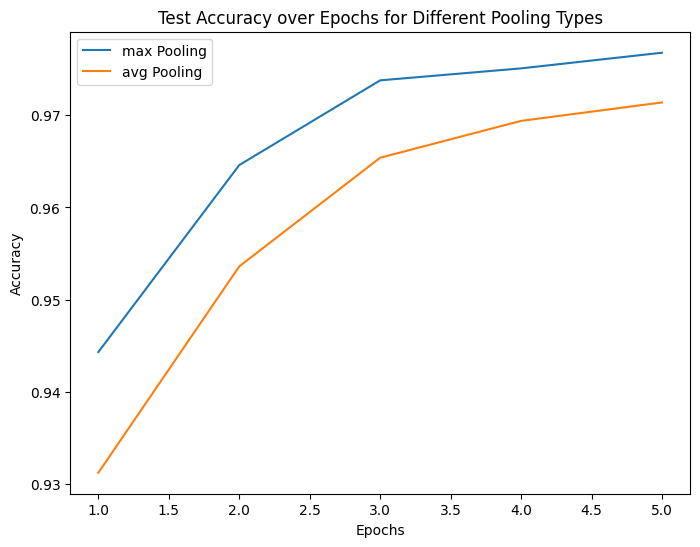

In [57]:
NUM_EPOCHS = 5
pooling_types = ['max', 'avg']

training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for pooling in pooling_types:
    print(f"\nTraining CNN with {pooling} pooling:\n")
    cnn = PoolingCNN(pooling_type=pooling)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

#Plotting one accuracy plot
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(len(pooling_types)):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=f"{pooling_types[i]} Pooling")
axs.set_title("Test Accuracy over Epochs for Different Pooling Types")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()



In [58]:
class VariableStrideAndPaddingCNN(nn.Module):

    def __init__(self, stride=1, padding=0):
        super().__init__()
        # Convolutional layers with stride for downsampling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=stride, padding=padding)

        # Fully connected layersdimension based on num_layers
        dimension = ((28 + 2 * padding - 3) // stride + 1) ** 2 * 16
        print("Dimension: ", dimension)
        self.fc1 = nn.Linear(dimension, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)

        # Fully connected layers
        x = self.fc1(x)

        return x

In [ ]:
NUM_EPOCHS = 5
STRIDE_OPTIONS = [1, 2, 4, 8]

training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for stride in STRIDE_OPTIONS:
    padding = 1
    print(f"\nTraining CNN with stride {stride} and padding {padding}:\n")
    cnn = VariableStrideAndPaddingCNN(stride=stride, padding=padding)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

#Plotting one accuracy plot
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(len(STRIDE_OPTIONS)):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=f"Stride {STRIDE_OPTIONS[i]}")
axs.set_title("Test Accuracy over Epochs for Different Stride Values")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()






Training CNN with stride 1 and padding 0:

Dimension:  10816
Epoch 1 done. Average train loss = 0.32, average train accuracy = 90.488%
Epoch 1 done. Average test loss = 0.16, average test accuracy = 95.580%
Epoch 2 done. Average train loss = 0.13, average train accuracy = 96.503%
Epoch 2 done. Average test loss = 0.11, average test accuracy = 97.010%
Epoch 3 done. Average train loss = 0.09, average train accuracy = 97.593%
Epoch 3 done. Average test loss = 0.08, average test accuracy = 97.510%
Epoch 4 done. Average train loss = 0.06, average train accuracy = 98.187%
Epoch 4 done. Average test loss = 0.08, average test accuracy = 97.680%


In [ ]:

PADDING_OPTIONS = [0, 1, 2, 3]
training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []
for padding in PADDING_OPTIONS:
    stride = 1  # Keep stride constant
    print(f"\nTraining CNN with padding {padding} and stride {stride}:\n")
    cnn = VariableStrideAndPaddingCNN(stride=stride, padding=padding)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

#Plotting one accuracy plot
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(len(PADDING_OPTIONS)):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=f"Padding {PADDING_OPTIONS[i]}")
axs.set_title("Test Accuracy over Epochs for Different Padding Values")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()